## New_Contributors_of_Commits
This is the reference implementation for [New Contributors of Commits](https://github.com/chaoss/wg-evolution/blob/master/metrics/pull-requests-merge-contributor-new.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing New_Contributors_of_Commits
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Visualizing the data extracted

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `../..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../..')

from implementations.code_df.commit_git import CommitGit
from implementations.code_df.conditions import (Naive,
                                                DirExclude,
                                                PostfixExclude)
from implementations.code_df.utils import str_to_date, read_json_file

In [2]:
class NewContributorsOfCommitsGit(CommitGit):
    """
    Class for New_Contributors_of_Commits.

    Initializes self.df, the dataframe with one commit per row.

    :param items: A list of dictionaries.
        Each item is a Perceval dictionary, obtained from a JSON
        file or from Perceval directly.

    :param date_range: A tuple which represents the start and end date
        between which new committers will be considered.
        Either, or both can be None. If, for example, since is None, that
        all unique contributors whose commit lies between the first first commit
        to the commit which last falls inside the until range would be considered
        unique contributors.

    :param is_code:  list of CodeCondition objects
        It is used to determine what comprises source code.

    :param conds: list of Commit sub-class objects.
        Used to add restrictions on which commits are
        included in the analysis.
        """

    def __init__(self, items, date_range=(None, None),
                 is_code=[Naive()], conds=[]):

        super().__init__(items, date_range, is_code, conds)

        self.df = self.df.loc[self.df.groupby('author')['created_date']
                              .idxmin()]

        since, until = date_range

        if since:
            self.df = self.df[self.df['created_date'] >= since]

        if until:
            self.df = self.df[self.df['created_date'] <= until]

    def _flatten(self, item):
        """
        Flatten a raw commit fetched by Perceval into a flat dictionary.

        A list with a single flat directory will be returned.
        That dictionary will have the elements we need for computing metrics.
        The list may be empty, if for some reason the commit should not
        be considered.

        This method overrides CommitGit._flatten and does not ignore commits
        based on the dates in date_range. The difference lies in the
        meaning of date_range for this metric when compared to the default
        meaning. For this metric, date_range signifies the dates between which
        we look for new contributors when compared to all contributors,
        while the general use of date_range is to decide which commits to consider
        for analysis.

        :param item: raw item fetched by Perceval (dictionary)
        :returns:    list of a single flat dictionary
        """

        creation_date = str_to_date(item['data']['AuthorDate'])

        code_files = [file['file'] for file in item['data']['files'] if
                      all(condition.check(file['file'])
                          for condition in self.is_code)]

        if len(code_files) > 0:
            flat = {
                'repo': item['origin'],
                'hash': item['data']['commit'],
                'author': item['data']['Author'],
                'category': "commit",
                'created_date': creation_date,
                'committer': item['data']['Commit'],
                'commit_date': str_to_date(item['data']['CommitDate']),
                'files_no': len(item['data']['files']),
                'refs': item['data']['refs'],
                'parents': item['data']['parents'],
                'files': item['data']['files']
            }

            actions = 0
            for file in item['data']['files']:
                if 'action' in file:
                    actions += 1
            flat['files_action'] = actions

            if 'Merge' in item['data']:
                flat['merge'] = True
            else:
                flat['merge'] = False

            return [flat]
        else:
            return []

    def compute(self):
        """
        Count the number of new committers who committed between the two dates
        of date_range.

        :returns count_of_new_committers: the number of new committers who
            committed between the dates of date_range

            Since the dataframe self.df is modified in __init__ via groupby
            and idmin(), the number of unique entries in the dataframe gives
            us the number of new committers between the given dates.
        """

        count_of_new_committers = len(self.df.index)
        return count_of_new_committers

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame or Series
        to count the number of new committers in a period when
        compared to committers before that period.

        This method uses the 'count' aggregation method.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The final aggregated DataFrame
        """

        df = df.resample(period)['author'].agg(['count'])
        return df

    def _get_params(self):
        """
        Return parameters for creating a timeseries plot

        :returns: A dictionary with axes to plot, a title
            and if use_index should be true when creating
            the plot.
        """

        title = "Trends in the Number of New Committers"
        x = None
        y = 'count'
        use_index = True
        return {'x': x, 'y': y, 'title': title, 'use_index': use_index}

    def __str__(self):
        return "New Contributors of Commits"

## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 

At its most basic, the `NewContributorsOfCommitsGit` class can be used to get the number of contributors over the entire interval for which commits are considered.

The `date_range` parameter talks about the period in which we will look for new contributors.

### Counting the total number of committers
We pass the data of the JSON file as a list to NewContributorsOfCommitsGit to start off. 

In [3]:
items = read_json_file('../git-commits.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any `since` and `until` dates. When no values are passed for `date_range`, every contributor to make a commit is a new contributor and hence, we get the total number of unique contributors in the data we considered.

In [4]:
new_committers = NewContributorsOfCommitsGit(items)
print("The total number of new committers is {}.".format(new_committers.compute()))

The total number of new committers is 29.


### Counting contributors in a specific range

Now, lets give the `date_range` tuple, which has `since` and `until` as its elements some values. Lets pass 2018-01-01 and 2018-07-01 for `date_range`. Thus, we will be looking for new contributors who made their first commit between 2018-01-01 and 2018-07-01.

We'll also add some filters on the number of commits: 
- exclude any commits that work solely on the tests directory
- exclude any commits solely dealing with markdown(.md) and files with the 

In [5]:
date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")
new_committers_interval = NewContributorsOfCommitsGit(
                                                    items, 
                                                    (date_since, date_until), 
                                                    is_code=[DirExclude(['tests']),
                                                             PostfixExclude(['.md', 'COPYING'])])

print("The total number of new committers between 2018-01-01 and 2018-07-01 in the file is {}."    \
                      .format(new_committers_interval.compute()))

The total number of new committers between 2018-01-01 and 2018-07-01 in the file is 5.


## Counting commits over regular time intervals
Using the `time_series` method, it is possible to compute the number of new committers for every month, or for every week. This kind of analysis is useful in finding trends over time, as we will see in the cell below. Let's see the trend in the number of new committers who first committed between the same dates we used above, on a weekly basis: 2018-01-01 and 2018-07-01. We will use the same object we used when working with the dates above: `new_committers_interval`

In [6]:
weekly_df = new_committers_interval.time_series(period='W')

Lets see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows corresponding to the weeks between the dates passed. This was done by performing a simple resampling with the desired time period.

In [7]:
weekly_df

,count
created_date,
2018-01-14,1
2018-01-21,0
2018-01-28,0
2018-02-04,0
2018-02-11,0
2018-02-18,1
2018-02-25,0
2018-03-04,0
2018-03-11,1


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple bar plot --- `new_committer` count vs time interval. 

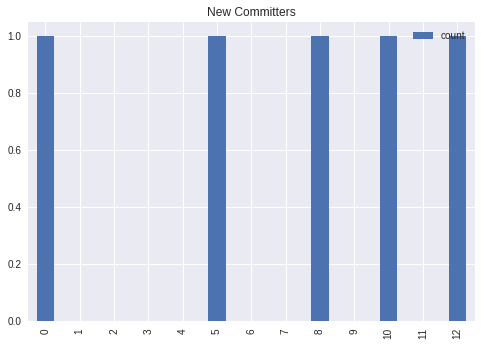

In [8]:
plt.style.use('seaborn')
weekly_df.plot(kind='bar', y='count', use_index=False)
plt.title("New Committers");

The same thing can be done for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale of each period. 

In [9]:
monthly_df = new_committers_interval.time_series(period='M')

In [10]:
monthly_df

,count
created_date,
2018-01-31,1
2018-02-28,1
2018-03-31,2
2018-04-30,1


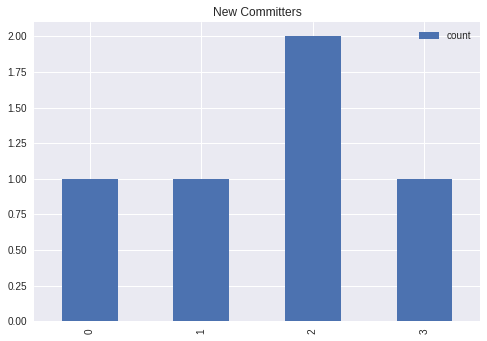

In [11]:
plt.style.use('seaborn')
monthly_df.plot(kind='bar', y='count', use_index=False)
plt.title("New Committers");